# Technical Project

# Analysis of Electrical Consumption 
### Data set: "Steel Industry Data"

### Ethan Gueck
### April 2024
___

___
### Organization: 

The notebook below is organized as follows. The index will provide hyperlinks to each section of the notebook and will outline the general organization of the notebook. The terms section will contain the definitions of the terms used throughout the notebook. The overview will explain the data, the problem, and briefly describe the methods and hypothesis. The preliminaries section is used to import all necessary packages and define the plotting functions that will be used throughout the notebook. The content of the notebook will contain the exploratory data analysis, the preliminary modeling and model testing, the final model implementation and testing, and the final results of the model selected. Lastly, the conclusion will summarize the results of the data exploration, provide insights into the model, and articulate model interpretation and future research.


___
### Index:
0. [Terms](#TERMS)
1. [Overview](#OVERVIEW)
2. [Preliminaries](#PRELIMS)
3. [Exploritory Data Analysis (EDA)](#Explore_the_Data)
4. [Problem Framing & Big Picture](#Problem_Framing_&_Big_Picture)
5. [Prepare the Data](#Prepare_the_Data)
6. [Preliminary Modeling](#Prelim_Modeling)
7. [Final Model](#Final_Model)
8. [Conclusion](#CONCLUSION)



___
### <a id="TERMS"></a>Terms:

- <b>Active Power</b>: Active power is the usable power delivered.
- <b>EDA: Exploratory Data Analysis</b>: The process of manipulating and visualizing the data with the intention of garnering insights into the implications and nature of the information contained therein.
- <b>Features / Attributes: </b> Features and attributes are used throughout the notebook interchangeably to describe unique columns or variables (i.e., the target column / feature / attribute: Lagging Power Factor).
- <b>Gradient Boost</b>: A gradient boost model or in the context of this notebook, a gradient boost regressor is a boosted (a sequential and incremental improvement approach) model based on the decision tree model.
- <b>Hyperparameters</b>: Hyperparameters are the variable input that will adjust a model's performance. These parameters can include variations in calculation algorithms, tolerance for error, number of iterations the model should run, etc...
- <b>MSE: Mean Squared Error: </b> Mean squared error is a common model testing algorithm that will assess how accurate the model is in predicting the target label.
- <b>Multicollinearity</b>: Multicollinearity is when two or more features are correlated with each other and with the target variable. This is not always a problem when isolating predictors but can cause issues. Just some of these issues include accuracy issues because of fit issues, obscuring actual predictors, by confusing them with correlation alone, and more.
- <b>Overfitting: </b> Overfitting is when a model is trained to predict the data very accurately in the training and or testing set but does not generalize to new data.
- <b>Power Factor</b>: Captures the relationship between the active power and the reactive power or resistance.
- <b>RMSE: Root Mean Squared Error: </b> Root Mean squared error is the square root of the Mean Squared error. RMSE is in the same scale as the target label.
- <b>Random Forest</b>: A random forest model is an ensemble machine learning model that utilizes a decision tree approach to classifying or regressing data.
- <b>Reactive Power</b>: Reactive power is the power that backflows into the system and is thereby unusable.
- <b>Power Unity</b>: Power unity or power factor unity occurs when the wavelength of the lagging and leading reactive power are alligned and results in the most actual power being delivered.
- <b>Ridge Regression</b>: Ridge regression implements the same base regression formula as linear regression but it penalizes features with multicollinearity by regularizing the coefficient.
- <b>SGD: Stochastic Gradient Decent</b>: Stochastic gradient descent is an optimization algorithm that when paired with a regression can discover an optimal regression by finding the gobal minimum for the coefficient.
- <b>SKLEARN</b>: SKLEARN or Sci kit learn is a package in Python designed to develop machine-learning and machine-learning adjacent code. It is used and referenced throughout this notebook.
- <b>Target Label:</b> Target label is the feature that is being predicted.

___
### <a id="OVERVIEW"></a>Overview:

The lagging Power Factor is an indicator of inefficiency in utility (power delivery) systems and is regulated by federal agencies, making it an optimal attribute to assess, model, and ultimately inform business decisions. This notebook is an exhibition of the "Steel Industry Data" set, which closely resembles meter information, and contains information on usage, leading and lagging reactive power, and interval information recorded throughout 2018. After processing this data set, three models are tested against each other to model the lagging reactive power factor, and ultimately a random forest model is selected to predict this attribute. The conclusion section of this notebook thoroughly describes the steps taken to understand and model this data, and the implications of this exploratory analysis. 

___
### <a id="PRELIMS"></a>Preliminaries:

In [207]:
# IMPORTS:

# General Imports.
import pandas as pd # Pandas import.
import sklearn # Sklearn import.
import matplotlib as mpl # Matplotlib import.
import matplotlib.pyplot as plt # Pyplot import.
import seaborn as sns # Seaborn import.
import numpy as np # Numpy import.
#import qbstyles 

# Specific imports.
# UNUSED: from pandas.plotting import scatter_matrix # Import scatter matrix for scatter matrix visual.
from matplotlib.colors import LinearSegmentedColormap # This is used to create a custom color map for matplotlib.
#from qbstyles import mpl_style

#Custom transformer was not needed. ||| from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder # The scaler and encoder were not necessary. ||| ,StandardScaler, OrdinalEncoder # These medods can be used to scale and encode the data if necessary.
from sklearn.model_selection import GridSearchCV # This method is used to perform a grid search on the models.
from sklearn.model_selection import train_test_split, cross_val_predict # This method will be used to split the data in to train/validate/test data.
from sklearn.metrics import mean_squared_error # MSE was used to asess model performance.

# Model Imports.
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


# SETTINGS: 
# Set matplotlib settings.
#mpl_style(dark=True)
plt.rc('font', size=11) # Set font size.
plt.rc('axes', labelsize=12, titlesize=12) # Set axis labels.
plt.rc('legend', fontsize=14) # Set legend.
plt.rc('xtick', labelsize=10) # Set x tick marks.
plt.rc('ytick', labelsize=10) # Set y tick marks.

# Set Pandas Settings.
pd.options.display.max_columns = 35 # Sets the max columns for data frames.
pd.options.display.max_rows = 1000 # Sets the max rows for data frames.
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Set dataframes to show floats with only 2 decimal places.


# PLOTTING FUNCTIONS: 
def modelPerformance(y_actual, y_pred, rmse, title=str('')): 
    plt.figure(figsize=(8, 6)) # Set figure size.
    for actual, predicted in zip(y_actual, y_pred): # Itterate through predictions and deliniate false passing (regulatory) predictions.
        if actual < 90 and predicted > 90: 
            plt.scatter(actual, predicted, color='red', alpha=1, marker='x', s=50) # Plot false passing predictions as red Xs.
        else:
            plt.scatter(actual, predicted, color='blue', alpha=0.5) # Plot all other predicted grades as blue bubles.
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], '--', color='red', label='Prediction line') # Add line to symbolize a perfect relationship.
    plt.axhline(y=90, color='red') # Set static line at 10 to deliniate failing grades.
    plt.fill_between([min(y_actual), max(y_actual)], min(y_actual), 90, color='lightcoral', alpha=0.3) # Shade below static x line to highlight failure predictions.
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual) + rmse, max(y_actual) + rmse], '--', color='black', label='+- Mean RMSE') # Plot positive street.
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual) - rmse, max(y_actual) - rmse], '--', color='black') # Plot negative street.
    plt.title(title + ' Model Predictions') # Set title.
    plt.xlabel('Actual Labels') # Set x label.
    plt.ylabel('Predicted Labels') # Set y label.
    plt.legend() # Set legend.
    plt.grid(True) # Set Grid.
    plt.show() # Show plot.

    i = 0
    # Itterate through predictions and count false passing predictions.
    for actual, predicted in zip(y_actual, y_pred):
        if actual < 90 and predicted > 90:
            i+=1
    print(f"Total number of predictions above 90 where actual Lagging Power Factor fell below 90: {i}")


In [208]:
# Warning Filters.
from sklearn.exceptions import ConvergenceWarning
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

___
### <a id="Explore_the_Data"></a>Exploritory Data Analysis (EDA):

In [209]:
data = pd.read_csv("Steel_industry_data.csv") # Import the CSV data and assign to data frame (DF). (Ensure CSV is in the same folder as program).
print(f"Head of data frame: \n {data.head(3)} \n ____________________\n ") # Display the top 3 rows of the data frame. 
print(f"Shape of data frame: \n {data.shape} \n ____________________\n ") # Print the shape of the DF.
print(f"Data info: \n {data.info()} \n ____________________\n ") # Display the value count break-down DF.

Head of data frame: 
                date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   
2                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   
2                         70.28                        100.00  2700   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load   
 ____________________
 
Shape 

In [210]:
# Rename column to follow format. !!! Unecessary for model production.
data.rename(columns={'Lagging_Current_Reactive.Power_kVarh': 'Lagging_Current_Reactive_Power_kVarh'}, inplace=True)

   month_year  Usage_kWh
0     2018-01  126238.29
1     2018-02   91497.34
2     2018-03   80230.41
3     2018-04   78769.80
4     2018-05   79059.28
5     2018-06   65404.64
6     2018-07   81674.41
7     2018-08   68559.43
8     2018-09   57883.07
9     2018-10   84665.65
10    2018-11   86217.61
11    2018-12   59436.78


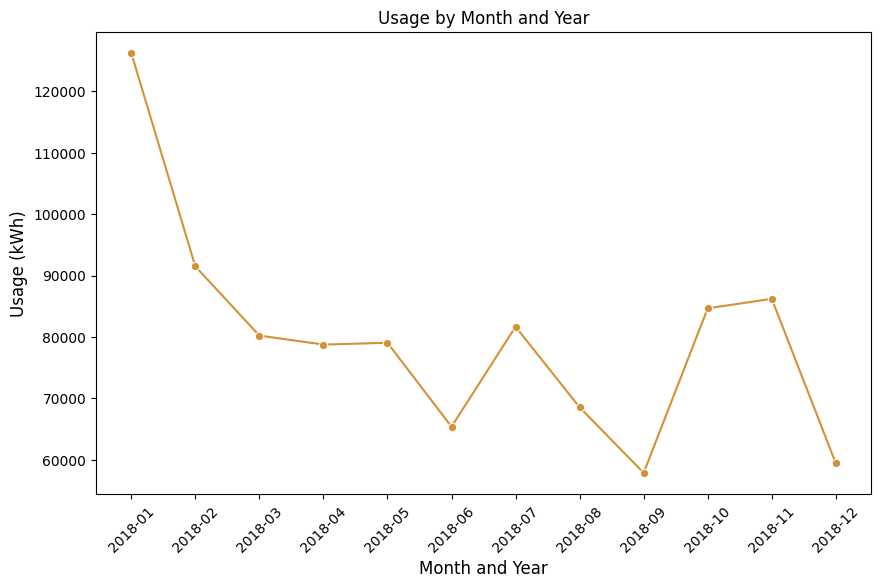

In [211]:
# This section will plot the usage over time, and is itended to gain some understanding of the general information contained in the data.
df_grouped_for_ts = data.copy()
df_grouped_for_ts['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%S') # Assign the date format.
df_grouped_for_ts['month_year'] = df_grouped_for_ts['date'].dt.to_period('M') # Create a year-month date bucket attribute.
df_grouped_for_ts = df_grouped_for_ts.groupby('month_year')['Usage_kWh'].sum().reset_index()
print(df_grouped_for_ts) # Print the grouped data.
df_grouped_for_ts['month_year'] = df_grouped_for_ts['month_year'].astype(str) # Ensure the month_year attribute is a str.

plt.figure(figsize=(10, 6)) # initialize plot.
sns.lineplot(x='month_year', y='Usage_kWh', data=df_grouped_for_ts, marker='o') # Assign line plot.
plt.title('Usage by Month and Year') # Set title.
plt.xlabel('Month and Year') # Set X labels.
plt.ylabel('Usage (kWh)') # Set y labels.
plt.xticks(rotation=45) # Set tick mark label rotation.
plt.show()

#### Categorical distribution insights:

Key takeaways:
When reviewing the distribution, take note of the right-skewed nature of the first four attributes and the left skew of the power factor (percentage) attributes which is constant with their raw data. Additionally, notice the very similar distribution of lagging reactive power and CO2. Plotting correlation is likely to provide some valuable insights as to whether these distributions are related.

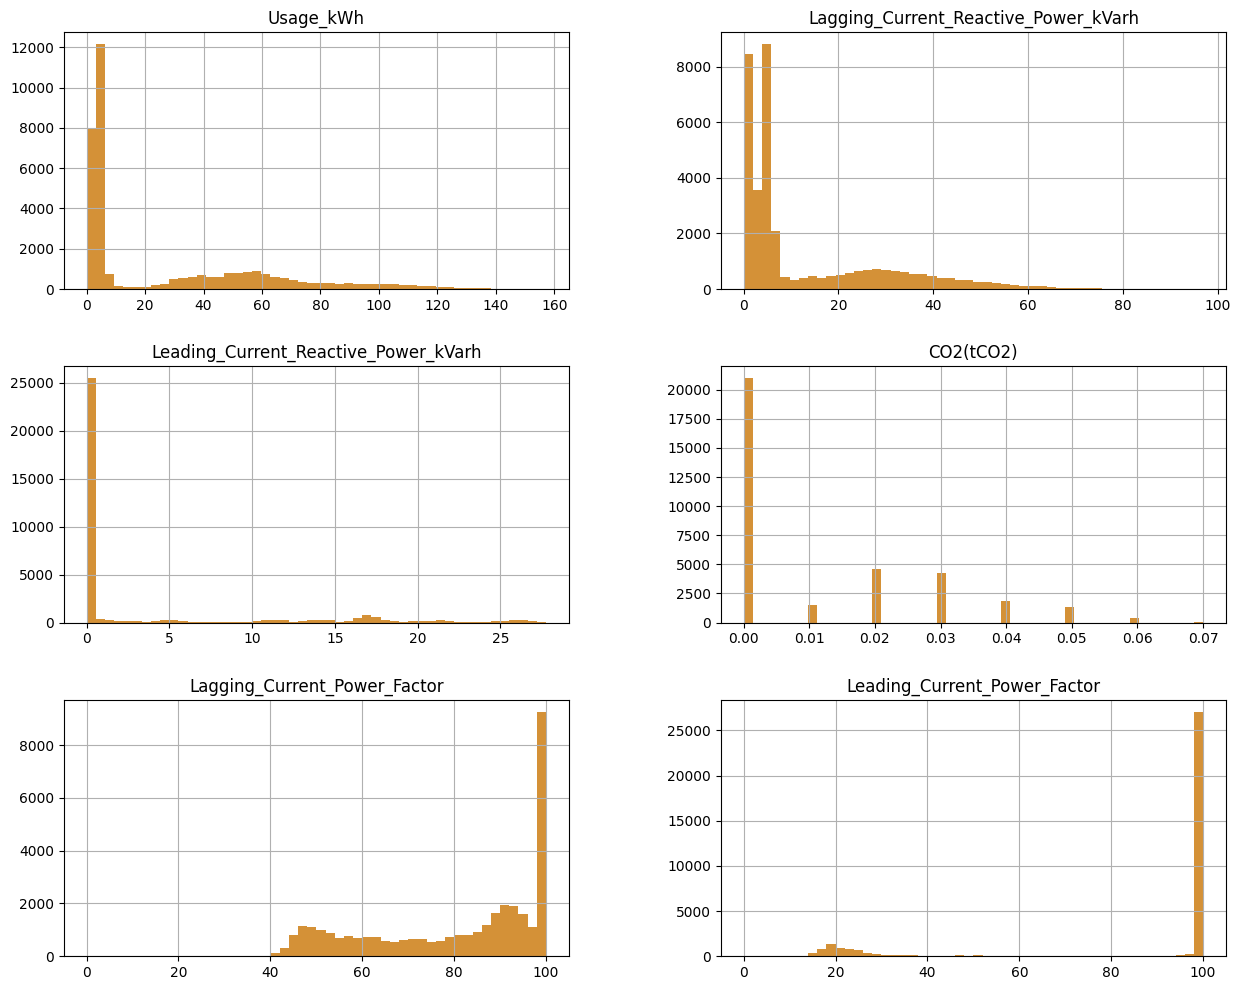

In [212]:
# View categorical data distribution. 
data_for_distribution_only = data.drop(columns=['date','NSM'])
data_for_distribution_only.hist(bins=50, figsize=(15, 12)) # Initialize the histogram.
plt.show() # Show plot.

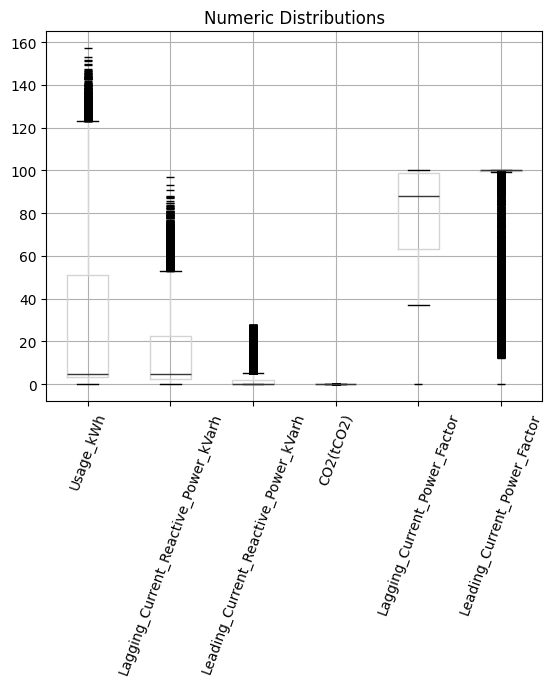

In [213]:
# Numeric data distribution.
plt.title('Numeric Distributions') # Set Title
ax = data_for_distribution_only.boxplot(figsize=(10, 14), rot=70, flierprops=dict(marker='_', markeredgecolor='black')) # Intialize box plot.
plt.show() # Show plot. 

In [214]:
print(f"Percentage of Usage (kWh) where lagging power factor fell below 90%: {round(data[data['Lagging_Current_Power_Factor'] < 90]['Usage_kWh'].sum() / data['Usage_kWh'].sum(),2)}%")

Percentage of Usage (kWh) where lagging power factor fell below 90%: 0.41%


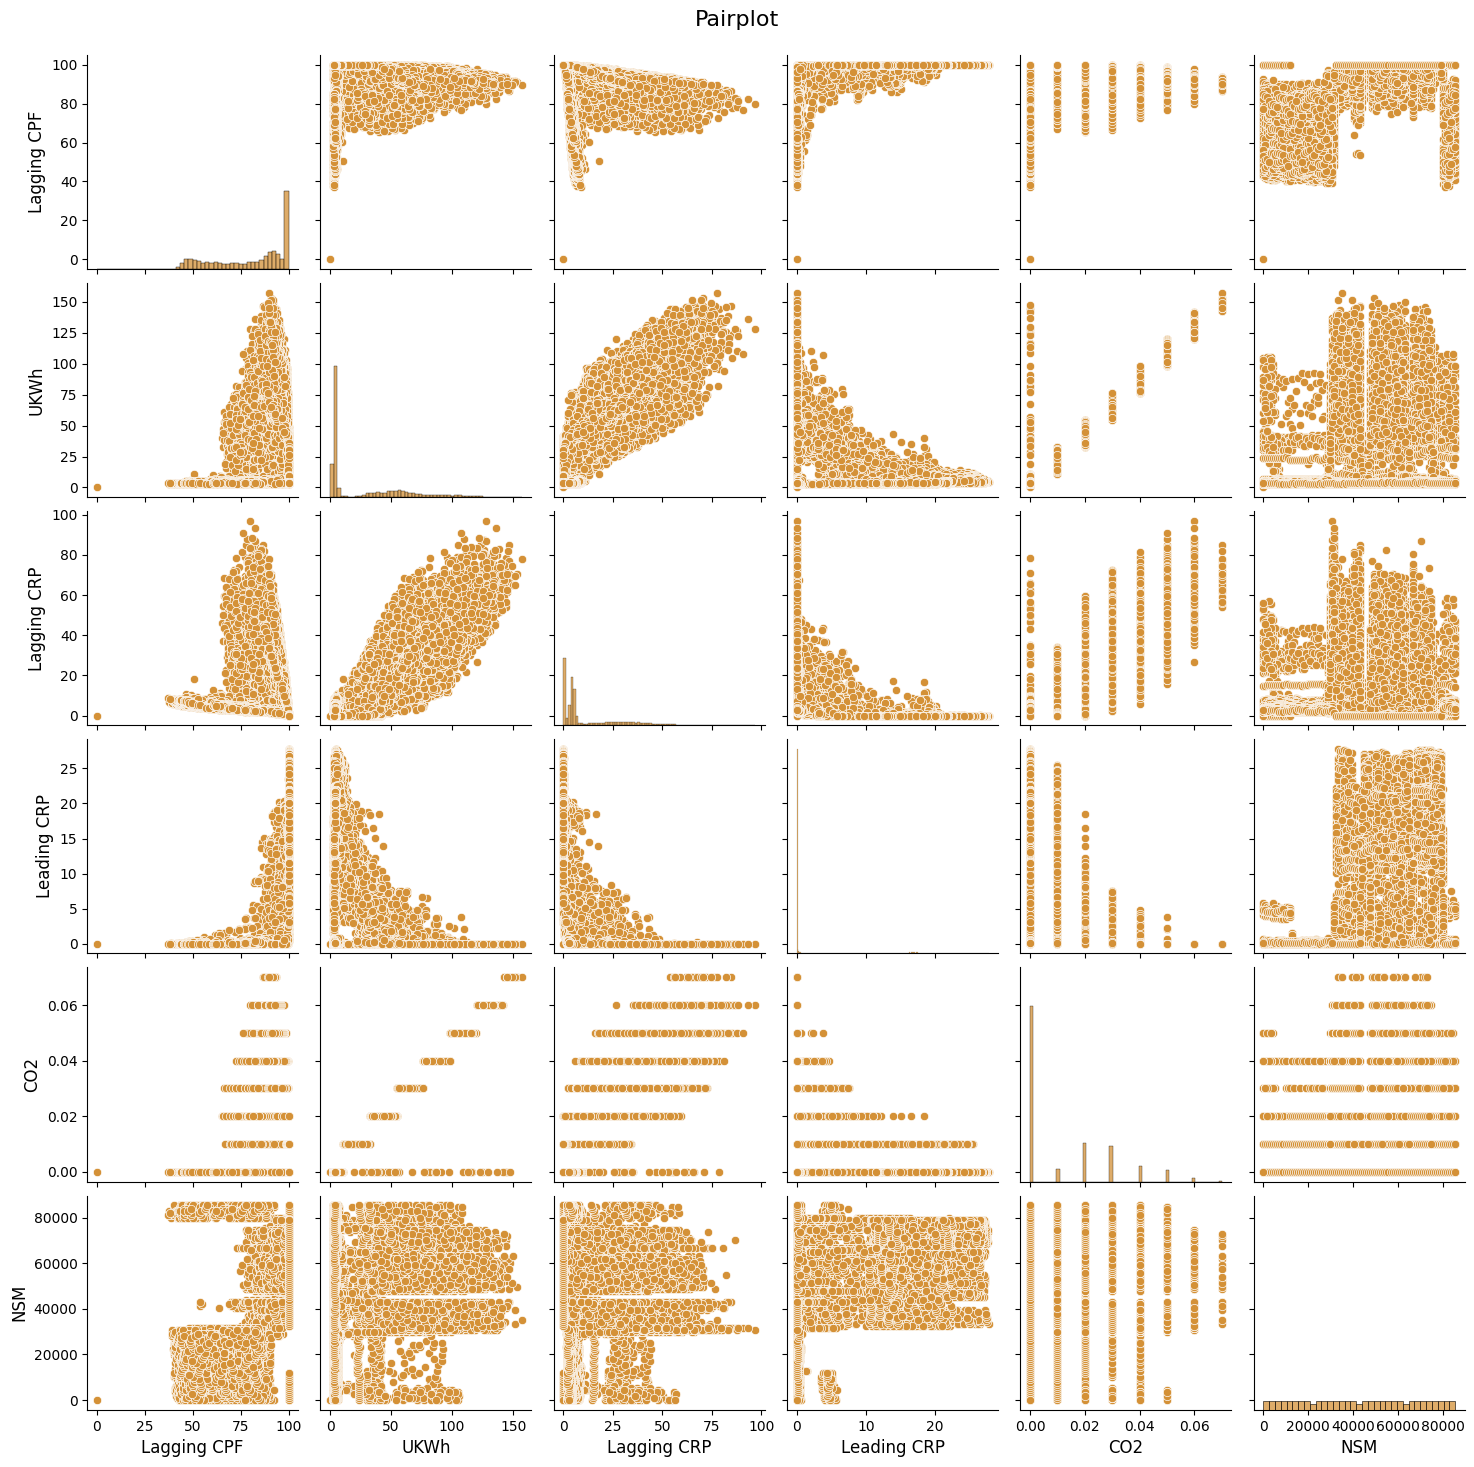

In [215]:
columns_of_interest = ['Lagging_Current_Power_Factor', 'Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'NSM'] # Select attributes.
colors = ['#D49137'] # Set Gold Color.
pairplot = sns.pairplot(data[columns_of_interest], kind='scatter') # Initialize pairplot.
axis_labels = ["Lagging CPF", "UKWh", "Lagging CRP", "Leading CRP", "CO2", "NSM"]  # Rename list.
# Itterate through labels and rename them.
for i, label in enumerate(axis_labels):
    pairplot.axes[-1, i].set_xlabel(label)
    pairplot.axes[i, 0].set_ylabel(label)
pairplot.fig.suptitle("Pairplot", fontsize=16) # Set plot name.
sns.set_palette(sns.color_palette(colors)) # Set colors to gold.
plt.subplots_adjust(top=0.95)  # Add margin for title.
plt.show() 

#### Concluding EDA:

Based on the attributes listed in the table it is apparent that "Usage" represented in kilowatts per hour is not directly representative of the active power consumption yet will be used in the conversion to kilowatts which will represent the active or "real" power consumption. The reactive power consumption is represented by the combination of the lagging and leading reactive power usage, and the apparent power consumption is not directly recorded in the data set however could be intuited by taking the square root of the sum of the squares of active and reactive power (the trigonometric relationship of power usage). 

<b>Potential value-add areas for modeling:</b>

Below are three (non-exhaustive) possible insights that could be modeled using the provided data. 

1. <b>Date-time informed projection. </b>
    - Question: What days and when is power most consumed?
2. <b>Inefficiency classification or regression. </b>
    - Question: What are the contributing factors to inefficiencies in the system? 
    - Inefficiencies could be measured by assessing the lagging reactive power which is an indicator of departure from power unity.
3. <b>CO2 projections and assessment.</b>
    - Question: What are the contributing factors to the CO2 generation?
    - CO2 generation can be an indicator of system inefficiency and there would be value in having a better understanding of the leading predictors of CO2 generation.

<b>Data cleaning and preparation:</b>
In the following section the data will be prepared and modeled. Below are some of the transformations and preparations considered.

- Isolating necessary data: what attributes should be filtered out if any.
- Null handling: The data set appears to be very clean and null handling or data imputation does not appear to be necessary.
- Outlier handling: Do outliers need to be filtered out of the data? 
- Data extrapolation: Active power is typically recorded in Watts (W) however usage in this dataset appears to indicate the "real" power consumption is recorded in kilowatts per hour (kWh). Some transformation would be necessary if the stakeholders are interested in discussing the data in watts.
- Categorical data: Categorical data should be transformed into numeric data treated as categorical data.
- Data scaling and normalization: Perform data scaling and normalization if necessary.
- Splitting the data: The data will need to be split into training, validation, and testing data.
- Post-data-preparation analysis: Correlation should be assessed once the data is processed.

___
### <a id="Problem_Framing_&_Big_Picture"></a>Problem Framing & Big Picture:

In an effort to provide exceptional utility-grade power, it is necessary to understand the areas of weakness and inefficiencies in the system. One indicator of inefficiency is the lagging reactive power as recorded by the 'Lagging_Reactive_Power_factor'. The lagging reactive power factor is identified by A. Bhatia with CEDEngineering as a key indicator of inefficiency in the power delivery system. Because the power factor is a percentage deviation from power unity, it provides a relative deviation from power unity. Moreover, the Federal Energy Regulatory Commission and Department of Energy regulations require the reactive power to remain between 95% leading and 95% lagging. For these reasons, this notebook will seek to predict the lagging power factor of the system based on the optimal predictors.

Refferences: (See also Refferences section.)

Lagging Power factor:
https://www.cedengineering.ca/userfiles/E04-014%20-%20Power%20Factor%20in%20Electrical%20Energy%20Management.pdf

Department of Energy Regulations:
https://www.ferc.gov/sites/default/files/2020-04/E-1_72.pdf


___
### <a id="Prepare_the_Data"></a>Prepare the Data (and Post Prep EDA):

In [216]:
# Step 1: Filter out unecessary data.
# No data to be filtered out at this time.
# Date attribute is addresed in a later step.

# Step 2: Null Handeling. 
# Data appears to be relatively clean and null handeling does not appear to be required.

# Step 3: Outlier handeling.
# Outliers will not be filtered out of the data because the model will attempts to have an understanding 
#  of outliers and how they impact potential inefficiencies.

After examining the data, it appears that each entry is representative of a 15-minute interval. Using this information the kilowattage consumed can be calculated using the below formula. 

P(W) = E(kWh) × 1,000 / T(hrs)

In the code below the Usage_kWh will be used to isolate the wattage consumed. 

In [217]:
# Step 4: Data Extrapolation.
#  GOALS: 
#   - Identify active (real) consumption, which is related but not the same as 'Usage_kWh'
data['active_power_w'] = data['Usage_kWh'] * 1000 / 0.25
print(data.head(3))

               date  Usage_kWh  Lagging_Current_Reactive_Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                  0.00       0.00   
1                                  0.00       0.00   
2                                  0.00       0.00   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                        100.00   900   
1                         66.77                        100.00  1800   
2                         70.28                        100.00  2700   

  WeekStatus Day_of_week   Load_Type  active_power_w  
0    Weekday      Monday  Light_Load        12680.00  
1    Weekday      Monday  Light_Load        16000.00  
2    Weekday      Monday  Light_Load        

In [218]:
# Step 5: Label encode categorical data:

# Map Day of week and load to manual label values.
day_of_week_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

load_mapping = {
    'Light_Load': 0, 
    'Medium_Load': 1, 
    'Maximum_Load': 2
}


label_encoders = {"Day_of_week": day_of_week_mapping, "Load_Type": load_mapping} # Label encoder dictionary.

for column in ["WeekStatus", "Day_of_week", "Load_Type"]:
    le = LabelEncoder() # Initialize the label encoder.
    if column == "Day_of_week": # Check to see if column is day of week. 
        data['Day_of_week'] = data['Day_of_week'].map(day_of_week_mapping)
    elif column == "Load_Type":
        data['Load_Type'] = data['Load_Type'].map(load_mapping)
    else: # If column is not weekday column categorize automatically. 
        le.fit(data[column]) # Fit data to column.
        data[column] = le.transform(data[column]) # Assign encoded values to column.
        label_encoders[column] = dict(zip(le.classes_, le.transform(le.classes_))) # Assign numeric codes and attribute names to key.

print("Encoded Data Value Counts:")
print(data[["WeekStatus", "Day_of_week"]].value_counts())

# Print Value counts to verify encoding.
print("\nKey:")
for column, encoder in label_encoders.items():
    print(f"{column}: {encoder}")

Encoded Data Value Counts:
WeekStatus  Day_of_week
0           0              5088
            1              4992
            2              4992
            3              4992
            4              4992
1           5              4992
            6              4992
Name: count, dtype: int64

Key:
Day_of_week: {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
Load_Type: {'Light_Load': 0, 'Medium_Load': 1, 'Maximum_Load': 2}
WeekStatus: {'Weekday': 0, 'Weekend': 1}


In [219]:
# Check data table.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  int32  
 9   Day_of_week                           35040 non-null  int64  
 10  Load_Type                             35040 non-null  int64  
 11  active_power_w 

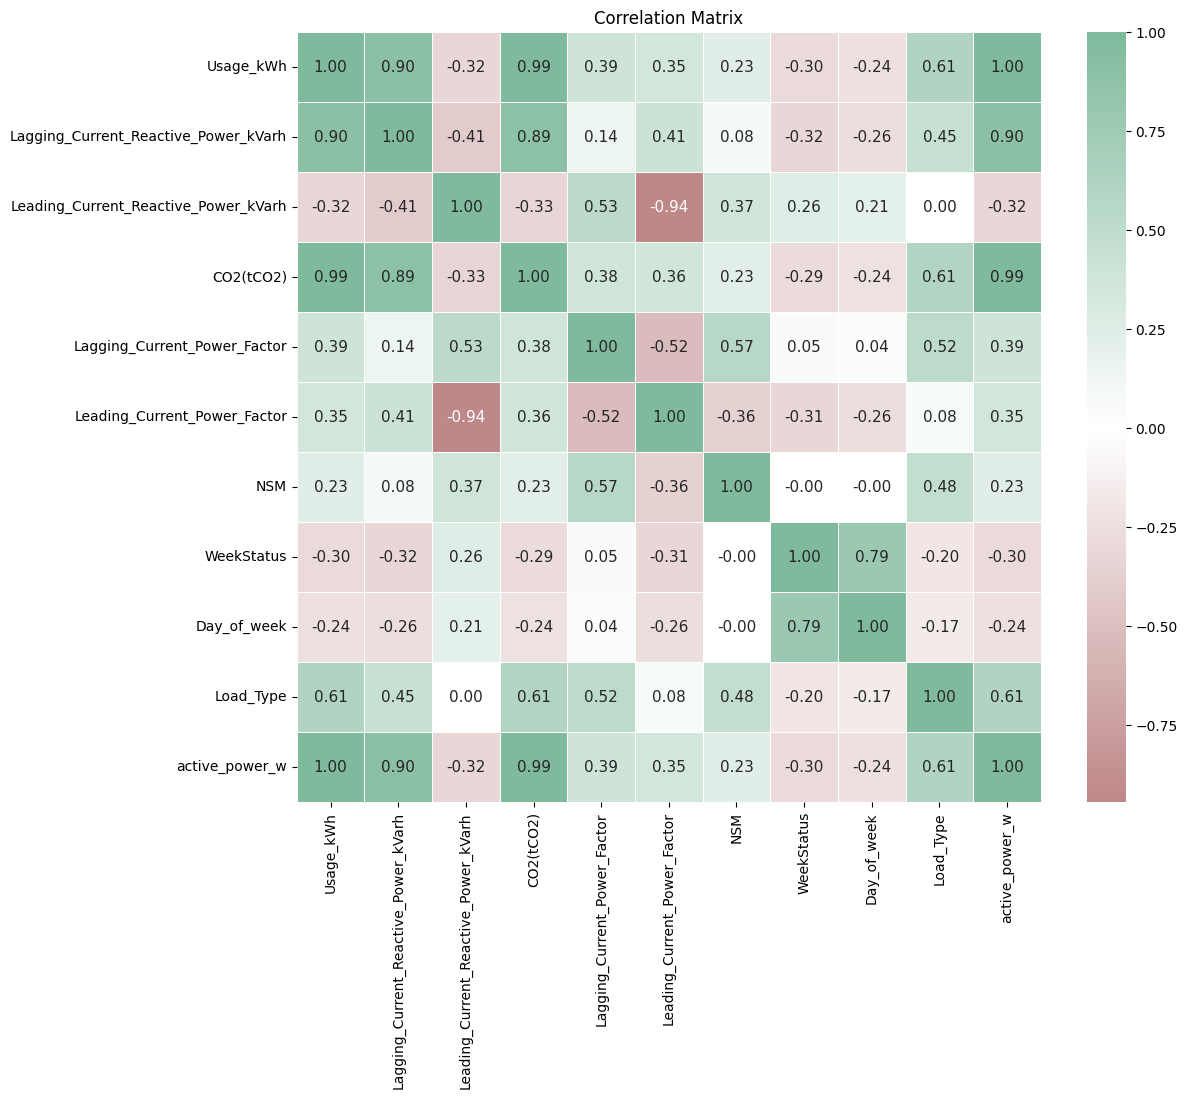

In [220]:
# Step 6: Post-preperatation EDA and transformation.
data_for_corr_matrix = data.drop(columns=['date']) # Remove date attributes (Not compatible with corr matricies).

correlation_matrix = data_for_corr_matrix.corr() # Set correlation matrix.
cor_pallet = [(186/255, 128/255, 129/255), (1, 1, 1), (128/255, 186/255, 156/255)] # Set custom color pallet; colors are in RGB.
cmap = LinearSegmentedColormap.from_list('RedWhiteGreen', cor_pallet) # Set gradient color map.
plt.figure(figsize=(12, 10)) # Set figure size.
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0, fmt=".2f", linewidths=0.5) # Initialize heat map.
plt.title('Correlation Matrix') # Set title.
plt.show() # Show plot.

In [221]:
data['day'] = pd.to_datetime(data['date'], dayfirst=True).dt.day # Add Day.
data['month'] = pd.to_datetime(data['date'], dayfirst=True).dt.month # Add Month. 
data['year'] = pd.to_datetime(data['date'], dayfirst=True).dt.year # Add Year.
data = data.drop(columns=['date']) # Drop Date-Time for formating.
# Notice I did not add time, this is because time is redundant with the 'NSM' (seconds from midnight) attribute.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive_Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  int32  
 8   Day_of_week                           35040 non-null  int64  
 9   Load_Type                             35040 non-null  int64  
 10  active_power_w                        35040 non-null  float64
 11  day            

In [222]:
# Print standard deviation.
for column in data_for_corr_matrix: 
    print(column + ": " + str(round(np.std(data[column]),2)))

Usage_kWh: 33.44
Lagging_Current_Reactive_Power_kVarh: 16.31
Leading_Current_Reactive_Power_kVarh: 7.42
CO2(tCO2): 0.02
Lagging_Current_Power_Factor: 18.92
Leading_Current_Power_Factor: 30.46
NSM: 24940.18
WeekStatus: 0.45
Day_of_week: 2.0
Load_Type: 0.79
active_power_w: 133775.61


In [179]:
# Step 7: Split data into validation and training sets.
X = data.drop(columns=['Lagging_Current_Power_Factor'])
y = data['Lagging_Current_Power_Factor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


___
### <a id="Prelim_Modeling"></a>Preliminary Modeling:

#### Key Insights about the data.

- Concentrated Distribution: The distribution of most of the attributes is rather condensed to a small portion of the scale. This indicates a small standard deviation leading to much of the attribute scale being classified as an outlier. This observation does not apply to the "date", "NSM", or other date/interval-related attributes which are very flat.
- Multicollinearity: Many of the attributes are very heavily correlated with each other. This can lead to issues in models that do not consider multicollinearity.

#### Model selection:

The following three models will be used to model the lagging reactive power and the reasons for using these models to compare performance are listed below.

<b>Ridge regression:</b>

- Resilient to outliers.
- Less likely to overfit.
- Can handle polynomial relationships.
- Can handle multicollinearity. 
- Can handle unscaled data.

<b>Random Forest:</b>

- Very resilient to outliers.
- Less likely to overfit.
- Can handle polynomial relationships.
- Can handle multicollinearity. 
- Can handle unscaled data.

<b>Gradient Boost:</b>

- Very resilient to outliers.
- Algorithmically complex.
- Can handle polynomial relationships.
- Can handle multicollinearity. 
- Can handle unscaled data.
- Potential Issues: 
    - Sensitive to outliers; at risk of overfitting. 
    - Computationally taxing.

#### Model plotting:

Models will be plotted with the following key. This is because these attributes represent a high correlation and should reasonably represent the model performance.
- X-axis: 'NSM'
- Y axis: 'Lagging_Current_Power_Factor'
- Z axis: 'load_type'
- Color range: 'active_power_w'


In [180]:
# Create results table: 
results_table = pd.DataFrame(columns=['Model', 'RMSE'])

#### Ridge Regression:

In [181]:
# Instantiate Ridge Model.
prelim_ridge_model = Ridge()

# Set hyperparamater dictionary for grid search.
ridge_params = {
    'alpha': [0.1, 1.0, 5.0],  # Regularization strength.
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Algorithm to use in the optimization problem.
    'max_iter': [500, 1000, 3000]  # Maximum number of iterations.
}

# Grid search model using 3 cross folds.
grid_search_ridge = GridSearchCV(estimator=prelim_ridge_model, param_grid=ridge_params, cv=3)

grid_search_ridge.fit(X_train, y_train) # Fit data.

# Isolate the best paramaters and the score.
best_params_rf = grid_search_ridge.best_params_
best_score_rf = grid_search_ridge.best_score_

print("Best parameters:", best_params_rf)
print("Best score:", best_score_rf)


c:\Users\egueck\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\egueck\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\egueck\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\egueck\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\egueck\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

Best parameters: {'alpha': 0.1, 'max_iter': 500, 'solver': 'auto'}
Best score: 0.7643380569657916


c:\Users\egueck\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [182]:
gb_model = grid_search_ridge.best_estimator_ # Use model with best hyperparamaters.
gb_model.fit(X_train, y_train) # Fit Data.
y_pred = gb_model.predict(X_valid) # Run prediction on validation data.
rmse_ridge = np.sqrt(mean_squared_error(y_pred, y_valid)) # Calculate RMSE.
results_table.loc[len(results_table)] = ['ridge', rmse_ridge] # Add rmse to results table.

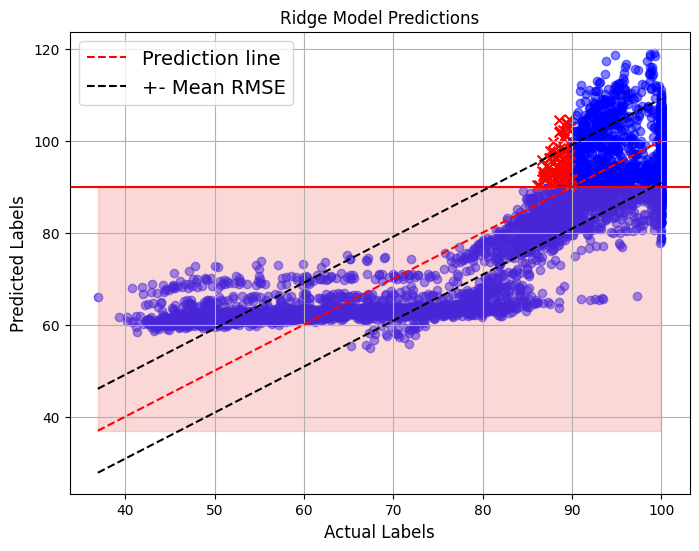

Total number of predictions above 90 where actual Lagging Power Factor fell below 90: 97


In [183]:
# Plot Ridge Regression Model.
modelPerformance(y_valid, y_pred, rmse_ridge, title=str('Ridge'))

#### Random Forest:

In [184]:
# Instantiate Random Forest Model.
prelim_rf_model = RandomForestRegressor()

# Set hyperparamater dictionary for grid search.
rf_params = {
    'max_depth': [3, 7, 10, 15],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 3, 4, 10] 
}

# Grid search model using 3 cross folds.
grid_search_rf = GridSearchCV(estimator=prelim_rf_model, param_grid=rf_params, cv=3)

grid_search_rf.fit(X_train, y_train) # Fit data.

# Isolate the best paramaters and the score.
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters:", best_params_rf)
print("Best score:", best_score_rf)


Best parameters: {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 100}
Best score: 0.9972883654400878


In [185]:
rf_model = grid_search_rf.best_estimator_ # Use model with best hyperparamaters.
rf_model.fit(X_train, y_train) # Fit Data.
y_pred = rf_model.predict(X_valid) # Run prediction on validation data.
rmse_rf = np.sqrt(mean_squared_error(y_pred, y_valid)) # Calculate RMSE.
results_table.loc[len(results_table)] = ['random_forest', rmse_rf] # Add rmse to results table.

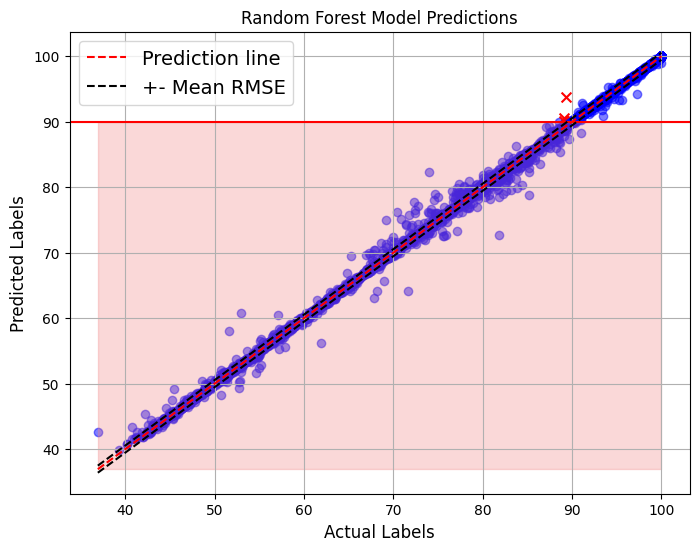

Total number of predictions above 90 where actual Lagging Power Factor fell below 90: 6


In [186]:
# Plot Random Forest Model.
modelPerformance(y_valid, y_pred, rmse_rf, title=str('Random Forest'))

#### Gradient Boost:

In [187]:
# Instantiate Gradient Boost Model.
prelim_gb_model = GradientBoostingRegressor()

# Set hyperparamater dictionary for grid search.
gb_params = {
    'max_depth': [2, 5, 10, 15],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Grid search model using 3 cross folds.
grid_search_gb = GridSearchCV(estimator=prelim_gb_model, param_grid=gb_params, cv=3)

grid_search_gb.fit(X_train, y_train) # Fit data.

# Isolate the best paramaters and the score.
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Best parameters:", best_params_gb)
print("Best score:", best_score_gb)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score: 0.9975803664832372


In [188]:
gb_model = grid_search_gb.best_estimator_ # Use model with best hyperparamaters.
gb_model.fit(X_train, y_train) # Fit Data.
y_pred = gb_model.predict(X_valid) # Run prediction on validation data.
rmse_gb = np.sqrt(mean_squared_error(y_pred, y_valid)) # Calculate RMSE.
results_table.loc[len(results_table)] = ['gradient_boost', rmse_gb] # Add rmse to results table.

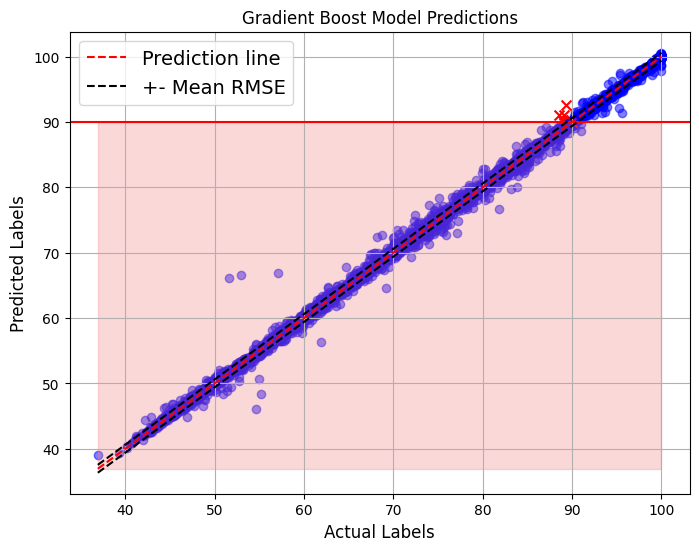

Total number of predictions above 90 where actual Lagging Power Factor fell below 90: 14


In [189]:
modelPerformance(y_valid, y_pred, rmse_gb, title=str('Gradient Boost'))

#### Model Comparison and Summary

In [190]:
try:
    results_table = results_table.drop_duplicates('Model')
except:
    pass
print(results_table)

            Model  RMSE
0           ridge  9.13
1   random_forest  0.54
2  gradient_boost  0.60


___
### <a id="Final_Model"></a>Final Model:

Although the gradient boost and the random forest model produced very similar results (this is not particularly surprising considering the gradient boost model implements a random forest regressor), the random forest model will be used as the final model. The random forest model was selected for the following reasons.

- The random forest model will likely generalize better.
- The model is less resource-intensive than the gradient boost and, therefore easier to maintain, even if the gradient boost was able to outperform the random forest model.
- The random forest model performed slightly better than the gradient boost, despite them having very similar hyperparameters.
- The random forest model has useful methods like plot importance that can aid in the model interpretation.

#### Final Model Tuning, Results, and Insights

In [198]:
final_rf_model = RandomForestRegressor() # Instantiate final model.

# Set hyperparamater dictionary for grid search.
final_rf_params = {
    'max_depth': [17, 18, 19],
    'n_estimators': [125, 150, 175],
    'min_samples_split': [2, 3] 
}

# Grid search model using 3 cross folds.
final_grid_search_rf = GridSearchCV(estimator=final_rf_model, param_grid=final_rf_params, cv=5)

final_grid_search_rf.fit(X_train, y_train) # Fit data.

# Isolate the best paramaters and the score.
final_best_params_rf = final_grid_search_rf.best_params_
final_best_score_rf = final_grid_search_rf.best_score_


In [199]:
print("Best parameters:", final_best_params_rf)
print("Best score:", round(final_best_score_rf,4))

final_rf_model = final_grid_search_rf.best_estimator_ # Instantiate final RF model.
final_rf_model.fit(X_train, y_train) # Fit the training data.
final_y_pred = final_rf_model.predict(X_test) # Predict the test data. 
final_rmse_rf = np.sqrt(mean_squared_error(final_y_pred, y_test)) # Calculate the final RMSE.
print(f"Final model RMSE: {round(final_rmse_rf,4)}")

Best parameters: {'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.9977
Final model RMSE: 0.5513


#### Final Model Assesment, Results, and Insights

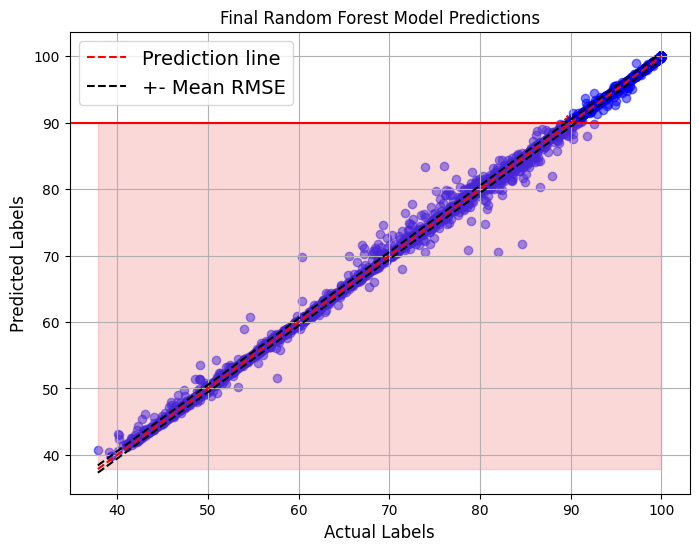

Total number of predictions above 90 where actual Lagging Power Factor fell below 90: 6


In [200]:
modelPerformance(y_test, final_y_pred, final_rmse_rf, title=str('Final Random Forest'))

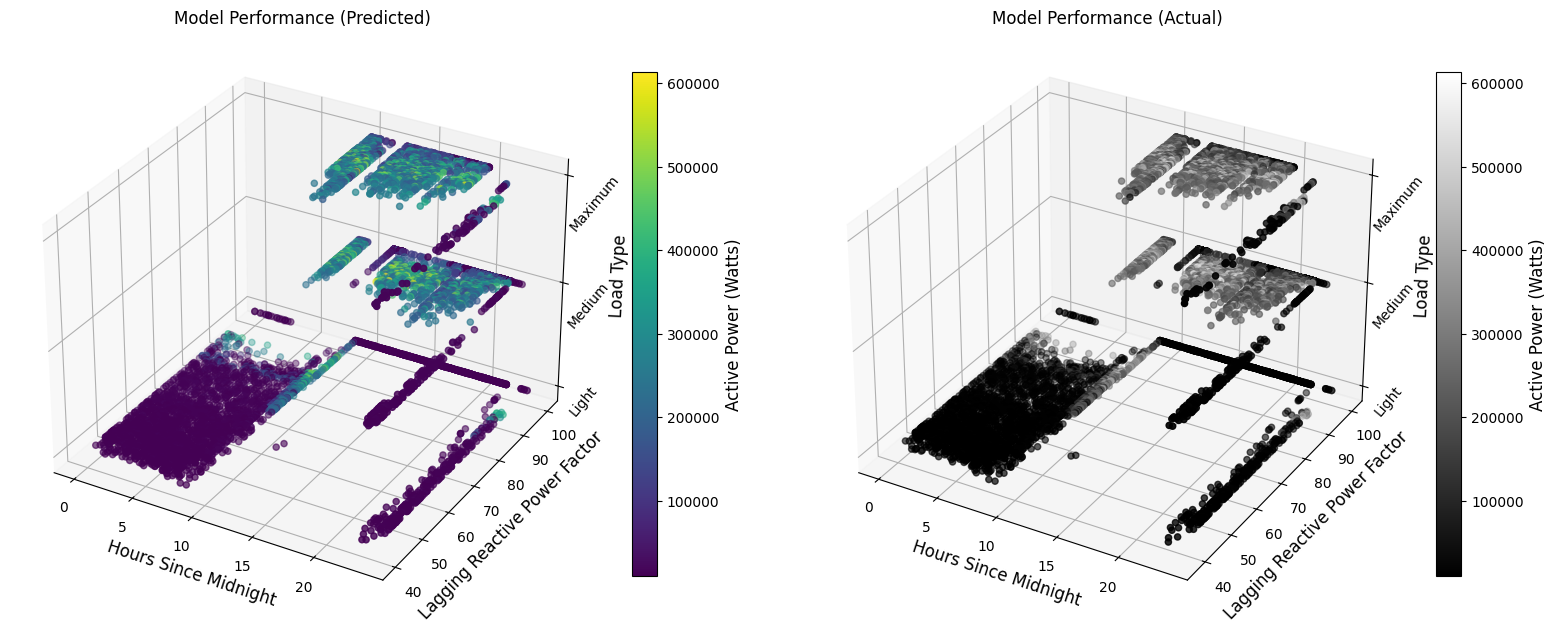

In [204]:
# Side by side comparison of model performance.

# This dictionary will be used to relabel the load type axis.
load_map_final = {
    'Light': 0, 
    'Medium': 1, 
    'Maximum': 2
}

fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'}) # Set Subplot grid.

# Add first subplot for predictions.
sc1 = axs[0].scatter(X_test['NSM'] / 3600, final_y_pred, X_test['Load_Type'], c=X_test['active_power_w'], cmap='viridis') # Add subplot.
axs[0].set_xlabel('Hours Since Midnight') # Set x label.
axs[0].set_ylabel('Lagging Reactive Power Factor')  # Set y label.
axs[0].set_zlabel('Load Type') # Set z label.
axs[0].set_title('Model Performance (Predicted)') # Set subplot title.
cbar1 = plt.colorbar(sc1, ax=axs[0], shrink=0.7) # Set Legend bar.
cbar1.set_label('Active Power (Watts)') # Set Legend title.
axs[0].set_zticks(list(load_map_final.values())) # Rename the load type tick marks.
axs[0].set_zticklabels(list(load_map_final.keys()), rotation=50) # Rename the load type tick marks.

# Add second subplot for actual labels.
sc2 = axs[1].scatter(X_test['NSM'] / 3600, y_test, X_test['Load_Type'], c=X_test['active_power_w'], cmap='gray') # Add subplot.
axs[1].set_xlabel('Hours Since Midnight') # Set x label.
axs[1].set_ylabel('Lagging Reactive Power Factor') # Set y label.
axs[1].set_zlabel('Load Type') # Set z label.
axs[1].set_title('Model Performance (Actual)') # Set subplot title.
cbar2 = plt.colorbar(sc2, ax=axs[1], shrink=0.7) # Set Legend bar.
cbar2.set_label('Active Power (Watts)') # Set Legend title.
axs[1].set_zticks(list(load_map_final.values())) # Rename the load type tick marks.
axs[1].set_zticklabels(list(load_map_final.keys()), rotation=50) # Rename the load type tick marks.

plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.05, wspace=0.1) # Adjust the subplot padding to make more room for the load type labels.
plt.show()

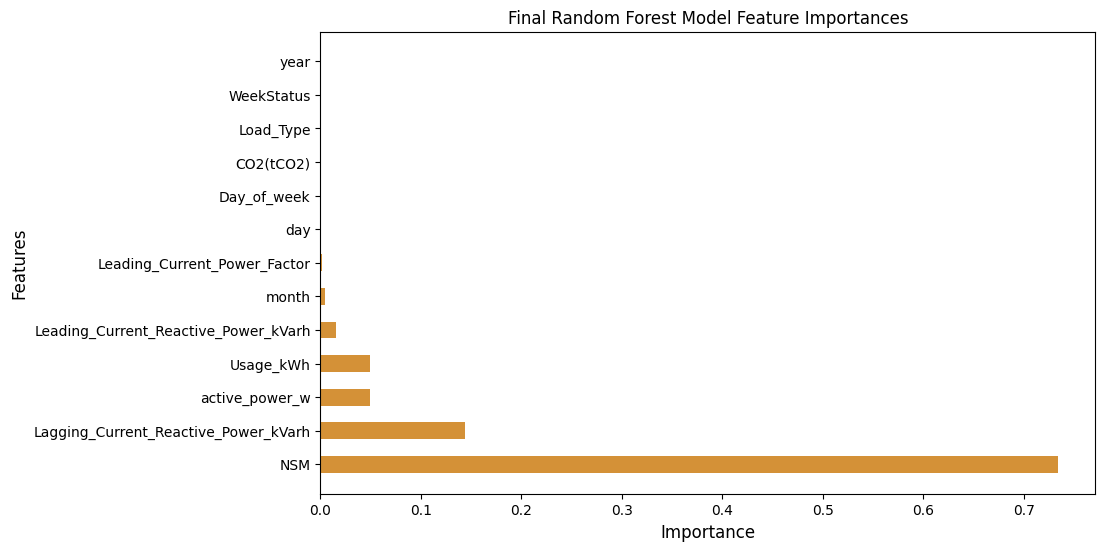

In [202]:
# Last but certainly not least: PREDICTOR IMPORTANCE: 
importances = final_rf_model.feature_importances_ # Get best predictors.
features = X_train.columns # Get column names.
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Final Random Forest Model Feature Importances") # Set Title.
plt.barh(range(X_train.shape[1]), importances[indices], align="center", height=0.5) # Set horizontal bar chart.
plt.yticks(range(X_train.shape[1]), features[indices]) # Set y tick labels.
plt.ylabel("Features") # Set y label. 
plt.xlabel("Importance") # Set x label. 
plt.show()

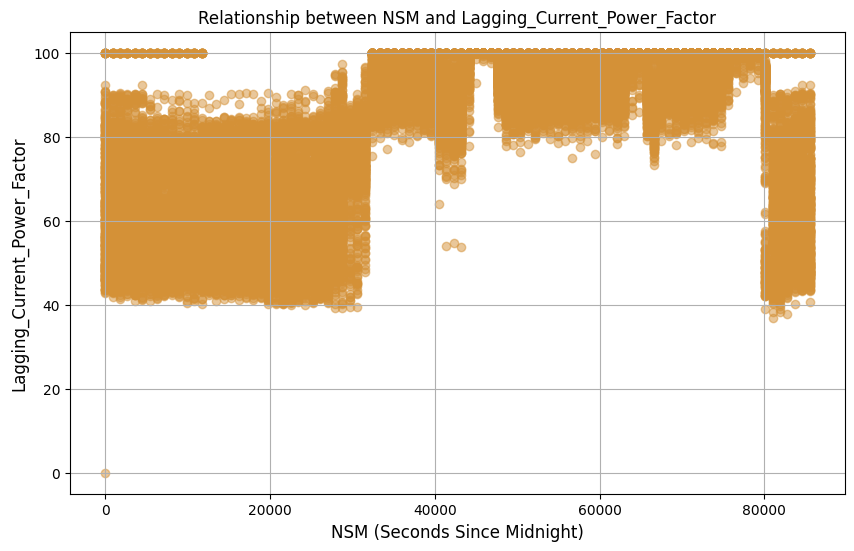

In [203]:
# Set Scatter for NSM and Lagging Power Factor.
plt.figure(figsize=(10, 6))
plt.scatter(data['NSM'], data['Lagging_Current_Power_Factor'], alpha=0.5) # Add scatter.
plt.title('Relationship between NSM and Lagging_Current_Power_Factor')  # Set title.
plt.xlabel('NSM (Seconds Since Midnight)') # Set x label.
plt.ylabel('Lagging_Current_Power_Factor') # Set y label.
plt.grid(True) # Set grid.
plt.show()

___
### <a id="CONCLUSION"></a>Conclusion:

#### Introduction

This notebook sought to exposit the assessment of the "Steel Industry Data" and provide valuable insights into potential opportunities presented by the data set. Of these aforementioned opportunities is the distribution of the lagging current power factor. The lagging current power factor is not only an indicator of system inefficiency, but regulatory agencies, i.e., the Department of Energy, require power suppliers to deliver power at a threshold of 95%. For these reasons, this notebook implemented a model to predict and qualify the lagging power factor, and provide insights into areas of inefficiency.

#### Methods

The methods and procedures herein are outlined below as well as the reasoning behind the major decision points in the process of modeling this data set.

- EDA:
    - The exploratory data analysis captured several key insights. 
    - Tangible results: There appeared to be multicollinearity present amongst the attributes. Furthermore, many of the attributes were linearly correlated and had a high presence of outliers.
    - Hypothesis and insights: Present in the data is information about the lagging reactive power which is an indication of system inefficiency as well as an industry-regulated feature. This can prove to be a valuable KPI as well as a very useful target attribute.

- Data Processing and Transformation:
    - Step 1: The date value was ultimately dropped in step 5 after converting date into its numeric components, i.e., month, day, year. 
    - Step 2: No imputation or null handling was required.
    - Step 3: Outliers were not filtered out because the outliers were instrumental in the modeling and data exploration.
    - Step 4: Active power reported in wattage was calculated using the 'Usage_kWh' attribute.
    - Step 5: Categorical data was given numeric values to conform to the accepted data types for the modeling. 
        - Not only were the catigorical values encoded but the date attribute was split into its components. Time was not included because of redndancy with NSM.
    - Step 6: The correlation of values was assessed.
        - Results of step 6: It is apparent that the 'CO2', Leading Power Factor, active power, and 'NSM' were highly correlated with the target label.
    - Step 7: The Data was split into the training, validation, and testing data.

- Model selection:
    - The primary contributing factors in the three models selected are as follows (Each model being a regression model because of the continuous target label.):
        - Can the model handle outliers?
        - Can the model handle multicollinearity?
        - Can the model be interpreted for a better understanding of the predictor relationships?
        - Can the model account for polynomial relationships? Although many of the relationships appear to be linearly related.
        - What is the computational trade-off and is the computational cost worth gains in accuracy?
    - Each one of the models selected should satisfy the above requirements. XGboost was considered for modeling this data, however, two of the three models performed well and required fewer computational resources than an XGboost model. Future research may benefit from the implementation of an XGboost model.

- Preliminary Model Testing: 
    - The preliminary model testing resulted in the exclusion of the ridge regression model for obvious underperformance (This may have been a result of not scaling the data or may be a result of poor hyper-parameter tuning). 
    - The random forest model and the gradient boost model were compared, and although they performed very similarly and, with some hyperparameter tuning the gradient boost model may have performed better, the random forest model was selected because it performed well, and the predictors can be easily extrapolated.
    - Each model was passed through a grid search with individual hyperparameters. The cross folds hyperparamater was kept at 3, future implementation may want to implement 5 cross folds.  
    - The models were then measured against each other through the comparison of the RMSE and visualization of the model performance.

- Final Model Tuning:
    - The final random forest model was once again passed through a grid search with the parameters being further narrowed to the previous optimal parameters as the hypothetical centroid and surrounding parameters were added. 
    - The following hyperparameters were passed through the final model grid search.
        - 'max_depth': [17, 18, 19]
        - 'n_estimators': [150, 200, 250]
        - 'min_samples_split': [2, 3]
    - The result of the grid search indicated the best hyperparameters were as follows:
        - 'max_depth': 19
        - 'n_estimators': 150
        - 'min_samples_split': 2

- Final model Results:
    - The final model appears to perform very well on the testing data with a final RMSE of 0.5513. 
    - Additionally, final model only predicted 6 lagging power factor labels as above 90% where the actual labels were below 90%.

#### Results 

The final model presented with an RMSE of 0.5513 and appears to predict the lagging power factor with both accuracy and without overfitting the data. For this reason, it is recommended that this model be used in predicting the lagging power factor.

Additionally, the results of this notebook indicate that the following are the key predictors.
- NSM or seconds from midnight.
- Lagging current reactive power.
- Active Power (watts)
- Usage (killowatt hours)
- Leading current reactive power.
- Month

#### Discussion

Data Insights:

The results of this research prompt several questions regarding the implications of the predictions. Before posing these questions, it is necessary to clearly identify some of the key data insights. Firstly, it is evident that the lagging power factor has a non-linear relationship with the 'NSM' or seconds from midnight. In the morning, and in the night the lagging power factor appears to be the lowest or least efficient. Additionally, the active power is affected by the reactive power as the system needs to use more power to achieve the intended throughput. The implications of this information should prompt an investigation into where in the system these inefficiencies are being manifested, and why the times of day affect the inefficiencies to such a great magnitude.

Process Analysis and Improvement:

Lastly, the model implementation must be further examined. For example, the inclusion of the Lagging_Current_Ractive_Power in the dataset contributes to the model performance. This is, of course, to be expected since the power factor is directly derived from this attribute. Excluding this attribute in the training and the modeling may make the data set more useful in modeling the Lagging power factor. Finally, polynomial transformation should be considered in the event the ridge regression model is reconsidered. It is likely that the lack of polynomial transfromation prior to implementation either caused or signifficantly contributed to the models poor performance.

#### Future Research

Future research should seek to provide additional insight into the specific units consuming the power so as to better identify weak points in the power delivery mechanism. This data should be captured in the process of transmission and at the point of delivery. Future modeling should focus on time series modeling for the usage as well as the lagging reactive power factor. Finally, a better understanding of the CO2 emissions should lead to a more comprehensive understanding of the system's efficiency.

___
### Refferences: 
https://control.com/technical-articles/active-power-reactive-power-apparent-power-and-the-role-of-power-factor/#:~:text=Active%20power%20is%20often%20called,power%20factor%20in%20DC%20circuits.

https://www.electrical-installation.org/enwiki/Definition_of_reactive_power#:~:text=Apparent%20power%3A%20S%20%3D%20V%20x%20I%20(kVA)

https://www.ferc.gov/sites/default/files/2020-04/E-1_72.pdf

https://www.federalregister.gov/documents/2024/03/28/2024-06556/compensation-for-reactive-power-within-the-standard-power-factor-range#:~:text=As%20a%20result%2C%20all%20newly,as%20a%20condition%20of%20interconnection.

https://www.electricaltechnology.org/2013/07/active-reactive-apparent-and-complex.html

https://eepower.com/technical-articles/power-factor-determining-how-much-electricity-your-power-system-consumes/#

https://www.cedengineering.ca/userfiles/E04-014%20-%20Power%20Factor%20in%20Electrical%20Energy%20Management.pdf

This cell is intentionally left empty.